In [3]:
# MLE Chart of Nuclides Project
# Nicholas March
# 661848406

# Imports
import numpy as np
import matplotlib.pyplot as plt
import periodictable
import pandas as pd
import seaborn as sns
from nuclide_data import nuclide_data as nd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras import optimizers
from keras.optimizers import Adam
from tensorflow.python.keras.optimizers import *
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from IPython.display import display, Math
plt.style.use('default')

Ratio of Stable to Unstable Data Points: 0.0972
If not ~ 1, indicates imbalanced dataset



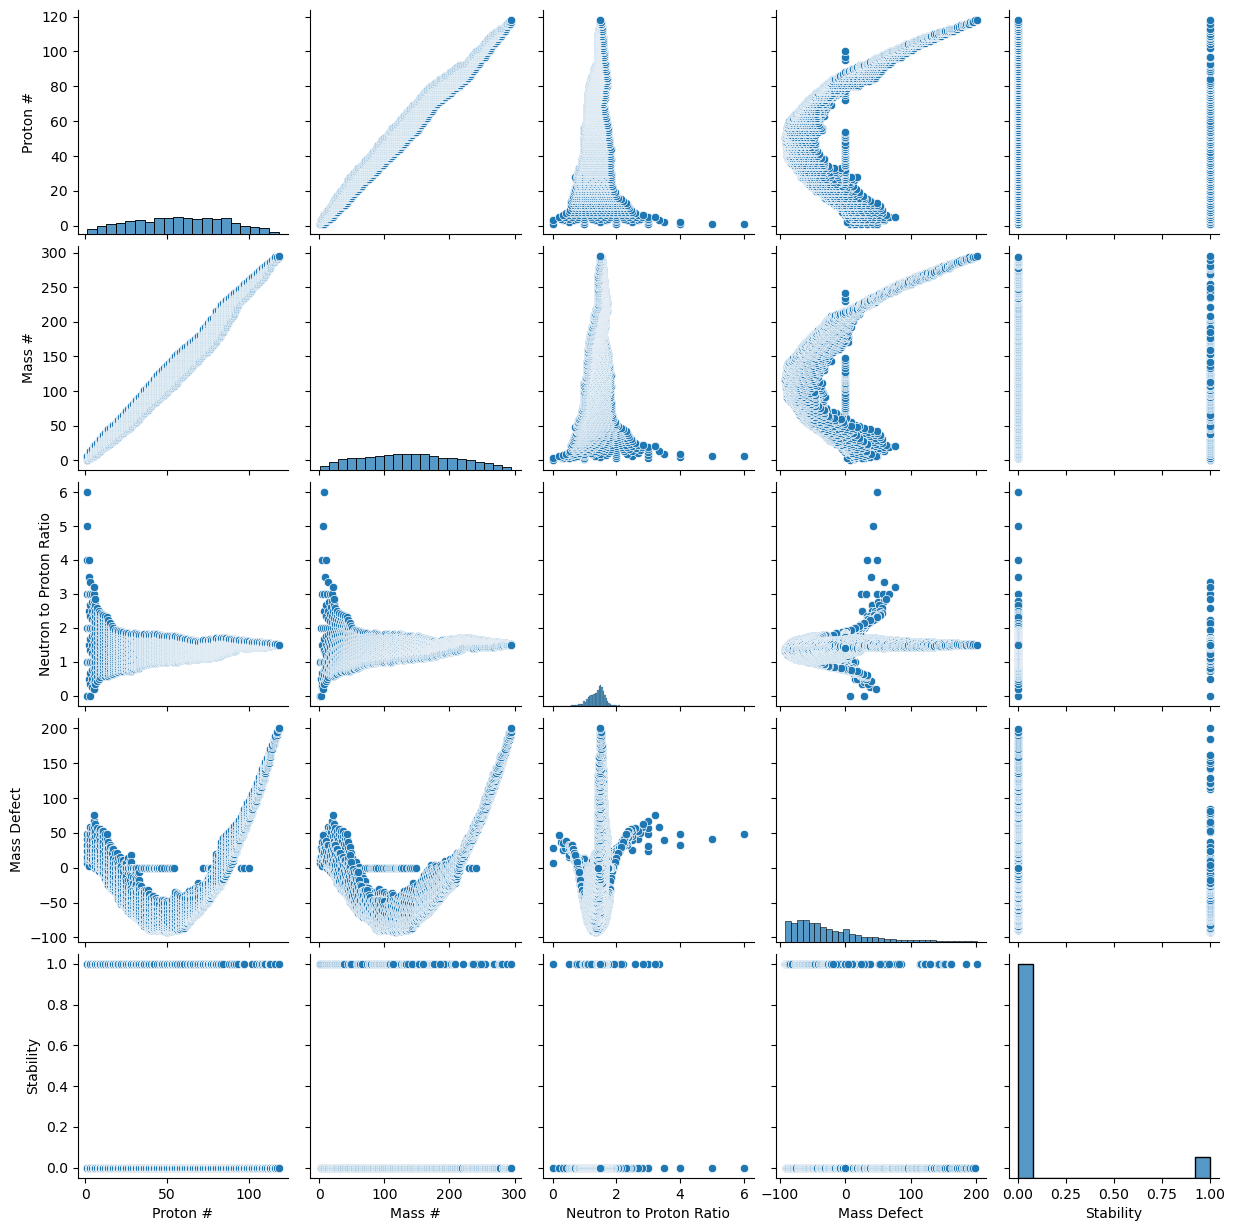

Feature Training Data Shape: (2338, 4)
Feature Testing Data Shape: (1002, 4)
Target Training Data Shape: (2338,)
Target Testing Data Shape: (1002,)


In [4]:
# Data Preprocessing

# Define a function to display isotopes
def iso(Z, A):
    element = periodictable.elements[Z].symbol
    latex_str = f"{{}}^{{{A}}}_{{{Z}}}\mathrm{{{element}}}"
    return latex_str

# Define data arrays and labels
x_data = []
y_data = []
feature_lbls = ["Proton #","Mass #","Neutron to Proton Ratio",
                "Mass Defect"]
target_lbl = "Stability"

# Read in feature and target data
Z_num = 1
while(Z_num < 120):
    A_num = Z_num
    nonexistent = 0
    while(nonexistent < 300):
        try:
            y_data.append(nd.nuclides[(Z_num, A_num)][0]['decay modes'])
            x_data.append([Z_num, A_num, (float(A_num/Z_num)-1.0), 
                           float(str(nd.nuclides[(Z_num, A_num)][0]['mass excess']).split("+")[0])])
        except KeyError:
            nonexistent += 1
        A_num += 1
    Z_num += 1

# Convert target labels to binary data
stable = 0
unstable = 0
for i in range(len(y_data)):
    if None in y_data[i].keys():
        y_data[i] = 1 # Stable
        stable += 1
    else:
        y_data[i] = 0 # Unstable
        unstable += 1
print("Ratio of Stable to Unstable Data Points:",round((stable / unstable),4))
print("If not ~ 1, indicates imbalanced dataset\n")

# Reformat data into numpy arrays
x_data = np.array(x_data)
y_data = np.array(y_data)

# Visualize data via pair plot
pairplot_data = pd.DataFrame(x_data, columns=feature_lbls)
pairplot_data[target_lbl] = y_data
sns.pairplot(pairplot_data)
plt.show()

# Split data into training and testing arrays
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data,
                                                    test_size=0.3,
                                                    random_state=5)    
    
# Remove rare / unwanted targets     WIP / Not Implemented
#for entry in y_data:
#    print(entry.keys())
#    try:
#        entry.pop('BA')
#    except KeyError:
#        None
    
# Display data shapes
print("Feature Training Data Shape:",x_train.shape)
print("Feature Testing Data Shape:",x_test.shape)
print("Target Training Data Shape:",y_train.shape)
print("Target Testing Data Shape:",y_test.shape)

In [54]:
# Hyperparameter Tuning

# Define parameter spaces
lr_space = [0.001, 0.00075, 0.0001]
dropout_space = [0.1, 0.25, 0.5]
l2_reg_space = [0.001, 0.0005, 0.0001]
init_neuron_space = [256, 512, 1024]
best_results = [0, 0, 0, 0, 0]
j = 0

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0)

# Define class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train.flatten()
)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Implement grid search
print("Conducting grid search...")
for lr in lr_space:
    for drp in dropout_space:
        for l2r in l2_reg_space:
            for init_neuron in init_neuron_space:
                j += 1
                opt_reduce_lr = tf.keras.optimizers.schedules.ExponentialDecay(lr, decay_steps=50,
                                                                           decay_rate=0.99,
                                                                           staircase=False)
                model = Sequential()
                model.add(Dense(init_neuron,input_dim=4,activation='relu', kernel_regularizer=l2(l2r)))
                model.add(BatchNormalization())
                model.add(Dropout(drp))
                model.add(Dense(init_neuron//2,activation='relu', kernel_regularizer=l2(l2r)))
                model.add(Dropout(drp))
                model.add(Dense(init_neuron//4,activation='relu', kernel_regularizer=l2(l2r)))
                model.add(Dropout(drp))
                model.add(Dense(1, activation='sigmoid'))
                opt_adam = Adam(learning_rate=opt_reduce_lr)
                model.compile(optimizer=opt_adam,
                              loss='binary_crossentropy',
                              metrics=['accuracy'])
                opt_history = model.fit(x_train, y_train,
                                    epochs=100,
                                    batch_size=64,
                                    validation_data=(x_test, y_test),
                                    class_weight=class_weight_dict,
                                    callbacks=[early_stopping], verbose=0)
                opt_test_loss, opt_test_acc = model.evaluate(x_test, y_test, verbose=0)
                if opt_test_acc > best_results[0]:
                    best_results = [opt_test_acc, lr, drp, l2r, init_neuron]
                print("Run #"+str(j),"  Accuracy:",round(opt_test_acc,4), "  Init LR:",lr,
                      "  Dropout:",drp,"  L2 Reg:",l2r,"  Init Neurons:",init_neuron)
                del model

# Output results
print("\nHyperparameter Tuning Results:")
print("Accuracy:",best_results[0])
print("Initial Learning Rate:",best_results[1])
print("Dropout Rate:",best_results[2])
print("L2 Regularization:",best_results[3])
print("1st Layer Neuron Number:",best_results[4])

Conducting grid search...
Run #1   Accuracy: 0.7016   Init LR: 0.001   Dropout: 0.1   L2 Reg: 0.001   Init Neurons: 256
Run #2   Accuracy: 0.8084   Init LR: 0.001   Dropout: 0.1   L2 Reg: 0.001   Init Neurons: 512
Run #3   Accuracy: 0.7395   Init LR: 0.001   Dropout: 0.1   L2 Reg: 0.001   Init Neurons: 1024
Run #4   Accuracy: 0.7864   Init LR: 0.001   Dropout: 0.1   L2 Reg: 0.0005   Init Neurons: 256
Run #5   Accuracy: 0.8144   Init LR: 0.001   Dropout: 0.1   L2 Reg: 0.0005   Init Neurons: 512
Run #6   Accuracy: 0.7675   Init LR: 0.001   Dropout: 0.1   L2 Reg: 0.0005   Init Neurons: 1024
Run #7   Accuracy: 0.8283   Init LR: 0.001   Dropout: 0.1   L2 Reg: 0.0001   Init Neurons: 256
Run #8   Accuracy: 0.7675   Init LR: 0.001   Dropout: 0.1   L2 Reg: 0.0001   Init Neurons: 512
Run #9   Accuracy: 0.8044   Init LR: 0.001   Dropout: 0.1   L2 Reg: 0.0001   Init Neurons: 1024
Run #10   Accuracy: 0.7595   Init LR: 0.001   Dropout: 0.25   L2 Reg: 0.001   Init Neurons: 256
Run #11   Accuracy: 0.7

In [7]:
# Optimized Model

# Define hyperparameters
init_lr = best_results[1]
drop_out = best_results[2]
l2_reg = best_results[3]
neurons = best_results[4]

# Define learning rate schedule
reduce_lr = tf.keras.optimizers.schedules.ExponentialDecay(init_lr, decay_steps=50,
                                                           decay_rate=0.99,
                                                           staircase=False)

# Define model
model = Sequential()
model.add(Dense(units=neurons,input_dim=4,activation='relu', kernel_regularizer=l2(l2_reg)))
model.add(BatchNormalization())
model.add(Dropout(drop_out))
model.add(Dense(units=neurons//2,activation='relu', kernel_regularizer=l2(l2_reg)))
model.add(Dropout(drop_out))
model.add(Dense(units=neurons//4,activation='relu', kernel_regularizer=l2(l2_reg)))
model.add(Dropout(drop_out))
model.add(Dense(1, activation='sigmoid'))

# Compile and fit model
adam = Adam(learning_rate=reduce_lr)
model.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    epochs=100,
                    batch_size=64,
                    validation_data=(x_test, y_test),
                    class_weight=class_weight_dict,
                    callbacks=[early_stopping], verbose=0)
print("Model compiled successfully.")

# Make predictions
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
test_preds = model.predict(x_test, verbose=0)
test_classes_pred = (test_preds > 0.5).astype("int32").flatten()

Model compiled successfully.



Test accuracy: 0.7625 

A selection of results from the test set:


<IPython.core.display.Math object>


Classification Report:

              precision    recall  f1-score   support

    Unstable       0.98      0.76      0.85       916
      Stable       0.24      0.83      0.37        86

    accuracy                           0.76      1002
   macro avg       0.61      0.79      0.61      1002
weighted avg       0.92      0.76      0.81      1002



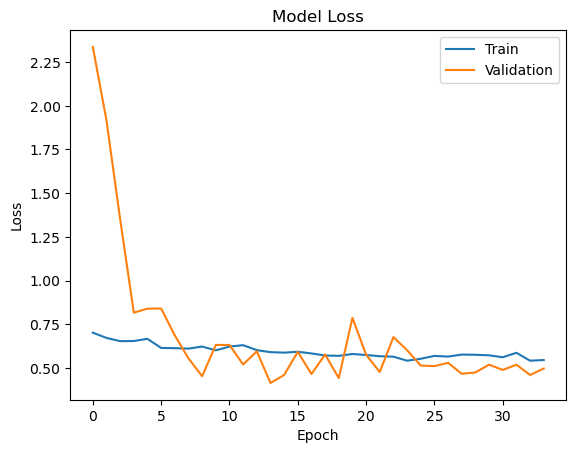

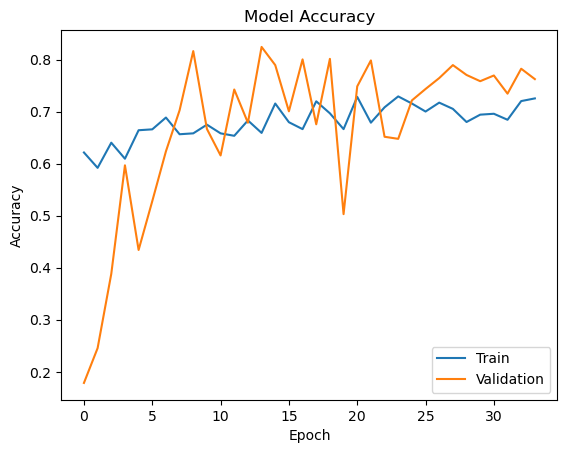

In [8]:
# Plotting and Results

# Print accuracy
print("\nTest accuracy:", round(test_acc, 4) , "\n")

# Print predictions and actual results for the first 5 test samples
print("A selection of results from the test set:")
latex_str = "\\begin{alignat*}{2}"
for i in range(5):
    Z_num_test = x_test[i][0]
    A_num_test = x_test[i][1]
    prediction = "Stable" if test_classes_pred[i] == 1 else "Unstable"
    actual = "Stable" if y_test[i] == 1 else "Unstable"
    latex_str += f"{iso(int(Z_num_test), int(A_num_test))} &:\\quad \\text{{Prediction: {prediction}}} &&\\quad|\\quad \\text{{Actual: {actual}}} \\\\"
latex_str += "\\end{alignat*}"
display(Math(latex_str))
    
# Print classification report
print("\nClassification Report:\n")
print(classification_report(y_test, test_classes_pred, target_names=["Unstable", "Stable"]))

# Plot loss curve
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot accuracy curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()